In [1]:
from EIS import EIS
import numpy as np

help(EIS)

Help on class EIS in module EIS:

class EIS(builtins.object)
 |  EIS(COM, BAUD=115200, timeout=0.1)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, COM, BAUD=115200, timeout=0.1)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  get_and_print_responses(self, print_response=False)
 |      Retrieve messages written by the teensy to the 
 |      serial connection under the assumption that the output is 
 |      utf-8 encoded. If this assumption is violated the resulting 
 |      exception is printed and an empty string is returned.
 |  
 |  get_data(self, stimulus_parameters, adc_type)
 |      This function can be used to get all the measured data for a single subtype.
 |      
 |      Parameters:
 |          
 |          stimulus_parameters: contains metadata on the stimulus.
 |          
 |          adc_type: 1. V1 
 |                    2. V2
 |                    3. DAC stimulus
 |          
 |      Output:
 |      
 |          data: a numpy array 

In [2]:
# Specify COM port to which teensy is attached
COM = 'COM9'  # /dev/ttyACM0 (Linux)

# ... and start an EIS instance 
myEIS = EIS(COM) 

print(myEIS.serial.name)

COM9


In [4]:
'''
Execute the measurements and save the results

Here a correct frequency range (f_range) should be picked, for this you need 
to analyse the circuit to find some ballpark figures.

Warning: frequencies used should adhere to the Shannon-Nyquist sampling theorem 
and they should respect the limitations of the acquisition electronics.

Known problem: sometimes a growing list of dots is shown and no further progress. 
If that happens the workaround is to interrupt the kernel and run this cell again.
''' 

f_max, f_step = 5001, 1000  # f_min is set to 0 below

space_style = [None, 'linear', 'logarithmic', 'handcrafted'][0]

if space_style == 'linear':
    f_range = np.arange(0, f_max, f_step)
elif space_style == 'logarithmic':
    f_range = np.logspace(np.log10(1), np.log10(f_max), 6) # log(0) is not defined
    f_range[0]= 0 # DC_value is important so put it back in
elif space_style == 'handcrafted':
    f_range = np.array([0,1,2,12,1212,])  # Just some handpicked values
elif 'f_range' not in locals():
    raise ValueError('f_range not initialized')

spectrum = myEIS.measure_spectrum(f_range, 
                                  f_sampling = 25000, 
                                  Rs= 1960,)

print(spectrum)

np.savez('spectrum__Rs1960Ohm.npz',spectrum=spectrum, f_range=f_range)


--------------------------------------------
Stimulus amplitude set to 0.600000

Sampling frequency for measuremnt set to 25000.000000

Stimulus DCValue set to 2048

Stimulus frequency set to: 0.000000

Measure at frequency 0
.{'stimulus_parameters_valid': 1, 'length': 2000, 'digital_amplitude': 1227.6, 'f_stimulus': 0.0, 'f_sampling': 25000.0, 'stimulus_duration': 80.0, 'ADC_averaging_number': 4}

--------------------------------------------
Stimulus amplitude set to 0.600000

Sampling frequency for measuremnt set to 25000.000000

Stimulus DCValue set to 2048

Stimulus frequency set to: 1000.000000

Measure at frequency 1000
.{'stimulus_parameters_valid': 1, 'length': 2000, 'digital_amplitude': 1227.6, 'f_stimulus': 1000.0, 'f_sampling': 25000.0, 'stimulus_duration': 80.0, 'ADC_averaging_number': 1}

--------------------------------------------
Stimulus amplitude set to 0.600000

Sampling frequency for measuremnt set to 25000.000000

Stimulus DCValue set to 2048

Stimulus frequency s

------------stimulus_parameters----------------
{'stimulus_parameters_valid': 1, 'length': 2000, 'digital_amplitude': 1227.6, 'f_stimulus': 5000.0, 'f_sampling': 25000.0, 'stimulus_duration': 80.0, 'ADC_averaging_number': 1}
-----------------------------------------------
{'start': 0, 'end': 100, 'data': [14058, 15133, 11839, 1737, -301, 9201, 17572, 13624, 3060, 666, 9891, 18085, 13992, 3350, 874, 10043, 18198, 14068, 3399, 921, 10077, 18230, 14097, 3419, 936, 10087, 18224, 14113, 3431, 942, 10087, 18209, 14107, 3421, 935, 10094, 18213, 14102, 3430, 935, 10091, 18215, 14113, 3427, 933, 10135, 18224, 14113, 3428, 938, 10090, 18240, 14113, 3415, 929, 10093, 18224, 14102, 3409, 930, 10087, 18228, 14113, 3421, 929, 10094, 18224, 14113, 3403, 933, 10093, 18231, 14113, 3418, 935, 10087, 18226, 14113, 3420, 930, 10091, 18215, 14113, 3430, 928, 10091, 18215, 14108, 3431, 938, 10091, 18215, 14113, 3422, 935, 10094, 18215, 14113, 3426, 937]}
-----------------------------------------------
{'sta

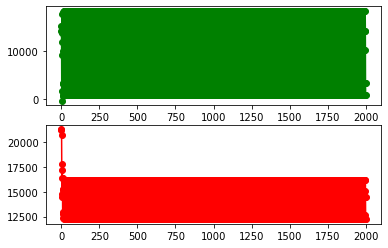

In [5]:
'''
Exposing some of the lower level functions used in te measurement below.
Gives a peak into the last executed measurement on the teensy.
'''
stimulus_parameters = myEIS.get_stimulus_parameters()  
print('------------stimulus_parameters----------------')
print(stimulus_parameters) 
print('-----------------------------------------------')
print(myEIS.get_data_slice(1, 0))
print('-----------------------------------------------')
print(myEIS.get_data_slice(2, 100))
print('-----------------------------------------------')
print(myEIS.get_data_slice(3, 2001))  
# sleep(0.1)
print('-----------------------------------------------')
print(myEIS.get_and_print_responses())
V1 = myEIS.get_data(stimulus_parameters, 1)
V2 = myEIS.get_data(stimulus_parameters, 2)
DAC = myEIS.get_data(stimulus_parameters, 3)


%pylab inline

plt.figure()
#plt.plot(np.array(V1),np.array(V2),'g.')
plt.subplot(2,1,1)
plt.plot(np.array(V1),'go-')
plt.subplot(2,1,2)
plt.plot(np.array(V2),'ro-')
#plt.plot(8*np.array(DAC), 'k.')

In [6]:
'''
Load earlier acquired data from file
'''

reload_data = False
if reload_data:
    spectrum_storage=np.load('spectrum__Rs1960Ohm.npz')
    spectrum = spectrum_storage['spectrum']
    f_range=spectrum_storage['f_range']

Populating the interactive namespace from numpy and matplotlib
[   0 1000 2000 3000 4000 5000] 1000 1.6e-07


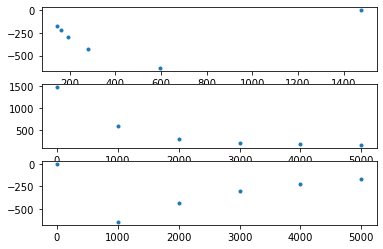

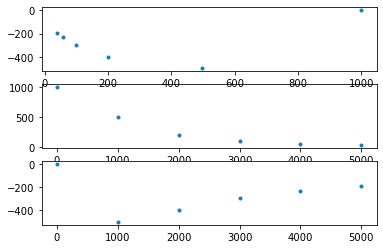

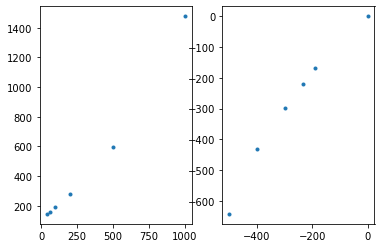

In [9]:
'''
Create plots of the measured data and a theoretical one for a known circuit. 

This way you can compare measurements on a known testcircuit with theory.

Todo: put info on axes.
'''

%pylab inline

reals = [np.real(response['Z']) for response in spectrum]
imaginaries = [np.imag(response['Z']) for response in spectrum]
frequencies = np.array([response['f_stim'] for response in spectrum])

R_testcircuit, C_testcircuit = 1000, 160*1e-9  # R in Ohm, C in Farad

print(frequencies, R_testcircuit, C_testcircuit)
Zomega = 1000/(1+1j*2*pi*frequencies*R_testcircuit*C_testcircuit)

# print(Zomega)
Zreals = [np.real(Z) for Z in Zomega]
Zimaginaries = [np.imag(Z) for Z in Zomega]

plt.figure()
plt.subplot(3,1,1)
plt.plot(reals, imaginaries,'.')

plt.subplot(3,1,2)
plt.plot(frequencies, reals,'.')

plt.subplot(3,1,3)
plt.plot(frequencies, imaginaries,'.')

plt.figure()
plt.subplot(3,1,2)
plt.plot(frequencies, Zreals, '.')

plt.subplot(3,1,3)
plt.plot(frequencies, Zimaginaries,'.')

plt.subplot(3,1,1)
plt.plot(Zreals, Zimaginaries,'.')


plt.figure()
plt.subplot(1,2,1)
plt.plot(Zreals, reals, '.')


plt.subplot(1,2,2)
plt.plot(Zimaginaries, imaginaries,'.')

